In [1]:
import numpy as np
import healpy as hp
import pandas as pd
from scipy import integrate
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [2]:
from completeness import create_completeness_dataframe

In [5]:
gkvInputCatv02_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/gkvInputCatv02/gkvInputCatv02.fits')[1].data
SM_cat_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data
efeds = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/eFEDS/eFEDS_clusters_V3.2.fits')[1].data  # todo: DID change to efeds

drivedrc = np.loadtxt('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/derivedrc.ascii', unpack = True)

In [43]:
nside=4096
z_max = 0.1 # ~430 Mpc
DEX = 0.25  # width of the mass bins
MASS_BINS = 10**np.arange(5,12.25,DEX)
HUBBLE_CST = 0.7

# todo: DID change to efeds RA & DEC
REGIONS_OF_SKY = {
    'G09': {'RAcen': (129.0, 141.0), 'DECcen': (-2.0, 3.0)},
}


# todo: change to efeds (should i really????)
GKV_MASKS = (
    (gkvInputCatv02_raw['uberclass'] == 1) &
    (gkvInputCatv02_raw['flux_rt'] > 10**-4.3) &
    (~gkvInputCatv02_raw['duplicate']) &
    (~gkvInputCatv02_raw['mask']) &
    (~gkvInputCatv02_raw['starmask'])
)
gkvInputCatv02 = gkvInputCatv02_raw[GKV_MASKS]

# todo: change to efeds (should i really????)
COMPLETENESS_MASKS = (
    (~SM_cat_raw['duplicate']) &
    (~SM_cat_raw['mask']) &
    (~SM_cat_raw['starmask']) &
    (SM_cat_raw['uberclass'] == 1) &
    (SM_cat_raw['mstar'] > 0) &
    (SM_cat_raw['flux_rt'] > 10**-4.3)
)

# todo: change to efeds (should i really????)
MASS_HISTOGRAM_MASKS = (
         (SM_cat_raw['uberclass'] == 1 ) & #galaxy
         (SM_cat_raw['duplicate'] == False) &
         (SM_cat_raw['mask'] == False) &
         (SM_cat_raw['starmask'] == False) &
         (SM_cat_raw['NQ'] > 2) &
         (SM_cat_raw['SC'] > 7) &
         (SM_cat_raw['mstar'] > 0) &
         (SM_cat_raw['Z'] < z_max) &
         (SM_cat_raw['flux_rt'] > 3631*10**(0.4*-19))
)

# todo: change to efeds
completeness_catalog = SM_cat_raw[COMPLETENESS_MASKS]
mass_histogram_catalog = SM_cat_raw[MASS_HISTOGRAM_MASKS]
print('mergedStellarMass_gkvScience, number of objects with SPEC_MASK:', len(completeness_catalog))
print('mass_histogram_catalog, number of objects with masks:',len(mass_histogram_catalog))

mergedStellarMass_gkvScience, number of objects with SPEC_MASK: 197083
mass_histogram_catalog, number of objects with masks: 18207


In [34]:
MS_regions = ['G09'] # todo: DID change to efeds
MS = {region_name: REGIONS_OF_SKY[region_name] for region_name in MS_regions}

MS_SM_cat = {region_name: mass_histogram_catalog[(
    (mass_histogram_catalog['RAcen'] >= region_params['RAcen'][0]) & (mass_histogram_catalog['RAcen'] <= region_params['RAcen'][1]) &
    (mass_histogram_catalog['DECcen'] >= region_params['DECcen'][0]) & (mass_histogram_catalog['DECcen'] <= region_params['DECcen'][1])
) ] for region_name, region_params in MS.items()}

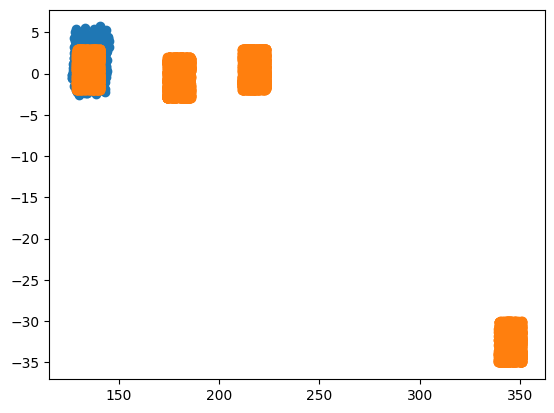

In [51]:

plt.scatter(efeds['RA'],efeds['DEC'])
plt.scatter(mass_histogram_catalog['RAcen'], mass_histogram_catalog['DECcen'])

In [35]:
# Function to get the weighted histogram of the objects of each region
def get_weighted_mass_histogram(input_mass_completeness_dataframe: pd.DataFrame, region_name: str):
    filtered_by_region_dataframe = input_mass_completeness_dataframe[input_mass_completeness_dataframe['region'] == region_name]
    mass_column = filtered_by_region_dataframe['mstar']
    completeness_column = filtered_by_region_dataframe['completeness']
    volume_richard_curve = get_region_volume(region_name=region_name, mass_list=mass_column)
    weight = np.log(10)/ (volume_richard_curve * completeness_column * DEX)
    return np.histogram(mass_column, MASS_BINS, weights=weight)[0]

# Function to get the volume of each region
def get_region_volume(region_name: str, mass_list: list):
    region = REGIONS_OF_SKY[region_name]
    region_area = calculate_patch_area(patch=region, nside=4096)
    average_pixel_area = 4 * np.pi / (12 * nside**2)
    total_area_sphere = hp.nside2npix(nside) * average_pixel_area
    fraction_region = region_area / total_area_sphere
    return calculate_volume([richard_curve(mass) for mass in mass_list], fraction_region)

# Function to calculate the area for a given patch
def calculate_patch_area(patch: dict, nside: int=4096):
    RA_min, RA_max = np.deg2rad(patch['RAcen'])
    DEC_min, DEC_max = np.deg2rad(patch['DECcen'])

    # Calculate the pixel indices for the given patch
    pix_indices = np.arange(hp.nside2npix(nside))
    pix_indices_patch = pix_indices[
        (hp.pixelfunc.pix2ang(nside, pix_indices)[0] >= np.pi/2 - DEC_max) &
        (hp.pixelfunc.pix2ang(nside, pix_indices)[0] <= np.pi/2 - DEC_min) &
        (hp.pixelfunc.pix2ang(nside, pix_indices)[1] >= RA_min) &
        (hp.pixelfunc.pix2ang(nside, pix_indices)[1] <= RA_max)
    ]

    # Calculate the area of the given patch using the average solid angle of a pixel
    average_pixel_area = 4 * np.pi / (12 * nside**2)
    patch_area = len(pix_indices_patch) * average_pixel_area

    return patch_area


x_r_curve = np.hstack((0, drivedrc[0], 1e13))
y_r_curve = np.hstack((0, drivedrc[1], drivedrc[1][-1]))



fun_MD = interp1d(x_r_curve, y_r_curve)
fun_MD(10**np.arange(9, 12, 0.1))
richard_curve = fun_MD

# Function to calculate volume (Mpc^3)
def calculate_volume(radius, fraction):
    return 4 / 3 * np.pi * np.power(radius, 3)  * fraction

# Function to calculate error
def calculate_error(y_data, N):
    return np.sqrt((y_data * N**(-1/2))**2 + (y_data * 0.043)**2)

In [36]:
def Rrichard_curve(x):
    """
    Richards curve from GAMA based on Table 5, Eq. 2 from Driver et al. 2022
    :param x: log10 of stellar mass limit
    :return: co moving distance  in Mpc
    """
    # todo: change to efeds
    A = -0.016
    K = 2742.0
    C = 0.9412
    B = 1.1483
    M = 11.815
    nu = 1.691
    y = A + (K - A) / (C + np.exp(-B * (x - M))) ** (1 / nu)
    return y


# Create an array of the stellar masses from the catalog
mstar_values = mass_histogram_catalog['mstar']

# Calculate the corresponding Richards curve values for each stellar mass
richards_curve_values = Rrichard_curve(np.log10(mstar_values))

In [37]:
completeness_all_df = pd.DataFrame()

# Loop over regions and create completeness DataFrames
for region_name, region_params in REGIONS_OF_SKY.items():
    # completeness_region_df = pd.DataFrame()
    completeness_region_df = create_completeness_dataframe(big_survey=gkvInputCatv02, # todo: change to efeds
                                                           small_survey=completeness_catalog,
                                                           flux_type='flux_rt',
                                                           region=region_name)
    completeness_region_df['region'] = region_name
    completeness_all_df = pd.concat([completeness_all_df, completeness_region_df], ignore_index=True)
print(completeness_all_df)

/home/farnoosh/Nextcloud/MasterThesis/codes/jupyternotebooks/completeness.py:34: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


                uberID  completeness region
0      138021052006945      0.962803    G09
1      131010293406270      0.902471    G09
2      136000563202354      0.899956    G09
3      130020205007803      0.958275    G09
4      132990039308055      0.957683    G09
...                ...           ...    ...
48916  130990634008739      0.926408    G09
48917  135021016609990      0.950147    G09
48918  135000832810514      0.958134    G09
48919  140000362709494      0.948196    G09
48920  137021074202062      0.932932    G09

[48921 rows x 3 columns]


In [38]:
mass_histogram_catalog_dataframe = pd.DataFrame()
mass_histogram_catalog_dataframe['uberID'] = mass_histogram_catalog['uberID'].byteswap().newbyteorder() # todo: change to efeds
mass_histogram_catalog_dataframe['mstar'] = mass_histogram_catalog['mstar'].byteswap().newbyteorder() # todo: change to efeds
mass_histogram_catalog_dataframe['comovingdist'] = mass_histogram_catalog['comovingdist'].byteswap().newbyteorder() # todo: change to efeds


In [39]:
# Merge completeness DataFrame with mass_histogram_catalog_dataframe based on 'uberID'
full_mass_completeness_dataframe = pd.merge(mass_histogram_catalog_dataframe, completeness_all_df,
                            on='uberID', how='left')